In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pygal 
from pygal import Config
from pywaffle import Waffle
from flask import Flask
from pygal.style import Style
# import sqviz as vz

%matplotlib inline

In [2]:
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
df = pd.read_csv(url, error_bad_lines=False)

In [4]:
df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [5]:
df_maine = df[df.state == 'Maine']

In [6]:
df_maine.date.max()

'2020-04-03'

In [7]:
df_maine.county.unique()

array(['Androscoggin', 'Cumberland', 'Lincoln', 'Unknown', 'Kennebec',
       'Oxford', 'York', 'Penobscot', 'Sagadahoc', 'Knox', 'Waldo',
       'Franklin', 'Somerset', 'Hancock', 'Aroostook', 'Washington'],
      dtype=object)

In [8]:
df_state_tot = df_maine.groupby('date').sum()

In [9]:
df_state_tot.head()

,fips,cases,deaths
date,,,
2020-03-12,23001.0,1,0
2020-03-13,46006.0,2,0
2020-03-14,46006.0,3,0
2020-03-15,69021.0,12,0
2020-03-16,69021.0,17,0


df_state_tot = df_state_tot.head().reset_index()

In [10]:
dates = df_state_tot.index.values.tolist()
cases = df_state_tot.cases.values.tolist()
deaths = df_state_tot.deaths.values.tolist()

In [11]:
dates_major = dates[0::3]

## Plot Total Cases and Deaths

In [12]:
bar_chart = pygal.Bar(x_label_rotation=20, show_minor_x_labels=False, show_legend=False, y_title = 'Number of Cases')
bar_chart.title = 'Total COVID-19 Cases in Maine'
bar_chart.x_labels = dates
bar_chart.x_labels_major = dates_major
bar_chart.add('Number of Cases', cases)

bar_chart.render_to_file('plots/total_cases_maine.svg')                          # Save the svg to a file

In [13]:
bar_chart = pygal.Bar(x_label_rotation=20, show_minor_x_labels=False, show_legend=False, y_title='Number of Deaths')
bar_chart.title = 'Total COVID-19 Deaths in Maine'
bar_chart.x_labels = dates
bar_chart.x_labels_major = dates_major

bar_chart.add('Deaths', deaths)

bar_chart.render_to_file('plots/total_deaths_maine.svg')                          # Save the svg to a file

## Plot New Daily Cases

In [14]:
df_state_tot['new_cases'] = df_state_tot.cases.diff()
df_state_tot['new_cases'][0] = 1

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
df_state_tot.head()

,fips,cases,deaths,new_cases
date,,,,
2020-03-12,23001.0,1,0,1.0
2020-03-13,46006.0,2,0,1.0
2020-03-14,46006.0,3,0,1.0
2020-03-15,69021.0,12,0,9.0
2020-03-16,69021.0,17,0,5.0


In [16]:
bar_chart = pygal.Bar(x_label_rotation=20, 
                      show_minor_x_labels=False,
                      show_legend=False,
                      y_title = 'Number of New Cases',
                      x_title = 'Day')
bar_chart.title = 'Daily New COVID-19 Cases in Maine'
bar_chart.x_labels = dates
bar_chart.x_labels_major = dates_major
bar_chart.add('Number of New Cases', df_state_tot.new_cases.to_list(), spacing=0)

bar_chart.render_to_file('plots/new_cases_maine.svg')                          # Save the svg to a file

## Plot Daily Deaths

In [17]:
df_state_tot['new_deaths'] = df_state_tot.deaths.diff()
df_state_tot['new_deaths'][0] = 0

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
df_state_tot.tail()

,fips,cases,deaths,new_cases,new_deaths
date,,,,,
2020-03-30,276194.0,275,4,22.0,1.0
2020-03-31,276194.0,303,5,28.0,1.0
2020-04-01,299203.0,344,7,41.0,2.0
2020-04-02,299203.0,376,7,32.0,0.0
2020-04-03,345235.0,432,9,56.0,2.0


In [19]:
bar_chart = pygal.Bar(x_label_rotation=20, 
                      show_minor_x_labels=False,
                      show_legend=False,
                      y_title = 'Number of Deaths')
bar_chart.title = 'Daily New COVID-19 Deaths in Maine'
bar_chart.x_labels = dates
bar_chart.x_labels_major = dates_major
bar_chart.add('Number of New Deaths', df_state_tot.new_deaths.to_list())

bar_chart.render_to_file('plots/new_deaths_maine.svg')                          # Save the svg to a file

## Plot County-Level Data

In [20]:
df_maine_today = df_maine[df_maine.date == df_maine.date.max()]

In [21]:
df_maine_today

,date,county,state,fips,cases,deaths
29400,2020-04-03,Androscoggin,Maine,23001.0,19,0
29401,2020-04-03,Aroostook,Maine,23003.0,1,0
29402,2020-04-03,Cumberland,Maine,23005.0,222,7
29403,2020-04-03,Franklin,Maine,23007.0,4,0
29404,2020-04-03,Hancock,Maine,23009.0,2,0
29405,2020-04-03,Kennebec,Maine,23011.0,19,1
29406,2020-04-03,Knox,Maine,23013.0,9,0
29407,2020-04-03,Lincoln,Maine,23015.0,8,0
29408,2020-04-03,Oxford,Maine,23017.0,10,0
29409,2020-04-03,Penobscot,Maine,23019.0,20,0


In [22]:
df_maine_today.sort_values(by=['cases'], ascending=False, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [23]:
bar_chart = pygal.Bar(x_label_rotation=20, show_legend=False, y_title='Number of Cases', x_title='County')
bar_chart.title = 'COVID-19 Cases by County (March 31, 2020)'
bar_chart.x_labels = df_maine_today.county.to_list()
bar_chart.add('Cases', df_maine_today.cases.to_list())

bar_chart.render_to_file('plots/current_cases_by_county.svg')                          # Save the svg to a file

##  County Case Growth

In [24]:
def create_days_to_double_data(df, days_to_double):
    cases= [1]
    n_days = len(df.date.unique())
    d = range(1,len(df.date.unique()))
    for day in d:
        cases.append(round(2**(day/days_to_double),2))
    return cases

Color pallette source: https://clrs.cc/

In [25]:
def get_custom_style():
    custom_style = Style(
    colors=['#85144B', '#111111', '#7FDBFF', '#39CCCC', '#3D9970', '#2ECC40', '#01FF70',
            '#FFDC00', '#FF851B', '#FF4136', '#F012BE', '#B10DC9', '#00008b', '#0074D9',
            '#6e6e6e', '#9e9e9e', '#dbdbdb'],
    label_font_size=14,
    major_guide_stroke_dasharray= '1.5,1.5'
    )

    return custom_style

def case_by_county_config():
    config = Config()
    custom_style = get_custom_style()
    config.style=custom_style
    config.x_label_rotation=20
    config.show_minor_x_labels=False
    config.y_labels_major_every=3
    config.show_minor_y_labels=False
    config.truncate_legend=-1 

    return config

In [26]:
def plot_county_lines(df_maine, line_chart):
    for county in df_maine.county.unique():
        if len(list(df_maine.date.unique())) == len(df_maine[df_maine.county==county].cases):
            case_data = df_maine[df_maine.county==county].cases
        else:
            len_diff = len(list(df_maine.date.unique())) - len(df_maine[df_maine.county==county].cases)
            case_data = df_maine[df_maine.county==county].cases.to_list()
            case_data = [0]*len_diff + case_data
        line_chart.add(county, case_data, dots_size=1.5)

In [27]:
config = case_by_county_config()

line_chart = pygal.Line(config,
                        y_title='Number of Cases',
                        height=500,
                        width=700)
line_chart.title = 'COVID-19 Case Growth by County'
line_chart.x_labels = list(df_maine.date.unique())
line_chart.x_labels_major = list(df_maine.date.unique())[0::3]
#add a line for each county
plot_county_lines(df_maine, line_chart)

line_chart.render_to_file('plots/growth_by_county.svg')                          # Save the svg to a file

In [28]:
config = case_by_county_config()

line_chart = pygal.Line(config,
                        y_title='Cases',
                        logarithmic=True,
                        height=500,
                        width=800                       )
line_chart.title = 'COVID-19 Case Growth by County (log scale)'
line_chart.x_labels = list(df_maine.date.unique())
line_chart.x_labels_major = list(df_maine.date.unique())[0::3]

#add a line for each county
plot_county_lines(df_maine, line_chart)

ref_style = stroke_style={'width':2.5}
line_chart.add('Cases Double every 4 Days', create_days_to_double_data(df_maine, 4),
              stroke_style=ref_style, dots_size=1)
line_chart.add('Cases Double every 5 Days', create_days_to_double_data(df_maine, 5),
               stroke_style=ref_style, dots_size=1)
line_chart.add('Cases Double every Week', create_days_to_double_data(df_maine, 7),
               stroke_style=ref_style, dots_size=1)


line_chart.render_to_file('plots/growth_by_county_log.svg')                          # Save the svg to a file

###### Cumberland

In [29]:
bar_chart = pygal.Bar(x_label_rotation=20, show_legend=False, y_title='Number of Cases', show_minor_x_labels=False)
bar_chart.title = 'COVID-19 Cases in Cumberland County'
bar_chart.x_labels = df_maine[df_maine.county=='Cumberland'].date.to_list()
bar_chart.x_labels_major = df_maine[df_maine.county=='Cumberland'].date.to_list()[0::3]
bar_chart.add('Cases', df_maine[df_maine.county=='Cumberland'].cases.to_list())

bar_chart.render_to_file('plots/cumberland_cases.svg')                          # Save the svg to a file

#### York

In [30]:
bar_chart = pygal.Bar(x_label_rotation=20, show_legend=False, y_title='Number of Cases', show_minor_x_labels=False)
bar_chart.title = 'COVID-19 Cases in York County'
bar_chart.x_labels = df_maine[df_maine.county=='York'].date.to_list()
bar_chart.x_labels_major = df_maine[df_maine.county=='York'].date.to_list()[0::3]
bar_chart.add('Cases', df_maine[df_maine.county=='York'].cases.to_list())

bar_chart.render_to_file('plots/york_cases.svg')                          # Save the svg to a file

#### Kennebec

In [31]:
bar_chart = pygal.Bar(x_label_rotation=20, show_legend=False, y_title='Number of Cases', show_minor_x_labels=False)
bar_chart.title = 'COVID-19 Cases in Kennebec County'
bar_chart.x_labels = df_maine[df_maine.county=='Kennebec'].date.to_list()
bar_chart.x_labels_major = df_maine[df_maine.county=='Kennebec'].date.to_list()[0::3]
bar_chart.add('Cases', df_maine[df_maine.county=='Kennebec'].cases.to_list())

bar_chart.render_to_file('plots/kennebec_cases.svg')                          # Save the svg to a file

## Cases Per Capita

#### County Population

https://data.census.gov/cedsci/profile?g=0500000US23005&q=Cumberland
https://data.census.gov/cedsci/profile?g=0500000US23031&q=York
https://data.census.gov/cedsci/profile?g=0500000US23017&q=Oxford
https://data.census.gov/cedsci/profile?g=0500000US23023&q=Sagadahoc
https://data.census.gov/cedsci/profile?g=0500000US23001&q=Androscoggin
    https://data.census.gov/cedsci/profile?g=0500000US23015&q=Lincoln
        https://data.census.gov/cedsci/profile?g=0500000US23011&q=Kennebec
https://data.census.gov/cedsci/profile?g=0500000US23007&q=Franklin
    https://data.census.gov/cedsci/profile?g=0500000US23027&q=Waldo
        https://data.census.gov/cedsci/profile?g=0500000US23025&q=Somerset
            https://data.census.gov/cedsci/profile?g=0500000US23009&q=Hancock
https://data.census.gov/cedsci/profile?g=0500000US23029&q=Washington
https://data.census.gov/cedsci/profile?g=0500000US23021&q=Piscataquis
    https://data.census.gov/cedsci/profile?g=0500000US23019&q=Penobscot
        https://data.census.gov/cedsci/profile?g=0500000US23003&q=Aroostook

In [32]:
population_data = {'Cumberland': 290944,
                   'York':203102,
                   'Oxford':57325,
                   'Sagadahoc':35277,
                   'Androscoggin':107444,
                   'Lincoln':34067,
                   'Kennebec':121545,
                   'Franklin':30019,
                   'Knox':39823,
                   'Waldo':39418,
                   'Somerset':50710,
                   'Hancock':54541,
                   'Washington':31694,
                   'Piscataquis':16877,
                   'Penobscot':151748,
                   'Aroostook': 68269,
                   'Unknown':np.nan}

In [33]:
df_population = pd.DataFrame.from_dict(population_data, orient='index',columns=['population'])
df_maine_today = df_maine_today.merge(df_population, left_on='county', right_index=True)
df_maine_today['cases_per_ten_thousand'] = df_maine_today.cases/ (df_maine_today.population/10000)
df_maine_today = df_maine_today.round({'cases_per_ten_thousand':1})

In [34]:
df_maine_today.head()

,date,county,state,fips,cases,deaths,population,cases_per_ten_thousand
29402,2020-04-03,Cumberland,Maine,23005.0,222,7,290944.0,7.6
29415,2020-04-03,York,Maine,23031.0,89,1,203102.0,4.4
29409,2020-04-03,Penobscot,Maine,23019.0,20,0,151748.0,1.3
29400,2020-04-03,Androscoggin,Maine,23001.0,19,0,107444.0,1.8
29405,2020-04-03,Kennebec,Maine,23011.0,19,1,121545.0,1.6


In [35]:
# Drop the Unknown county column
unknown_idx = df_maine_today[df_maine_today.county=='Unknown'].index
df_maine_today = df_maine_today.drop(labels=unknown_idx, axis=0)

In [36]:
# Drop the Unknown county row
unknown_idx = df_maine_today[df_maine_today.county=='Unknown'].index
df_maine_today = df_maine_today.drop(labels=unknown_idx, axis=0)

# plot the data
bar_chart = pygal.Bar(x_label_rotation=20,
                      show_legend=False,
                      y_title='Cases per 10,000 Residents',
                      x_title='County')
title_text = 'COVID-19 Cases per 10,000 Residents' + ' (' + \
              str(df_maine_today.date.max()) + ')'
bar_chart.title = title_text
bar_chart.x_labels = df_maine_today.county.to_list()
bar_chart.add('Cases per 10,000 Residents', df_maine_today.cases_per_ten_thousand.to_list())

bar_chart.render_to_file('plots/current_cases_per_hundred_thous.svg')                          # Save the svg to a file

## Make a df with Press Herald Data (https://www.pressherald.com/2020/03/17/track-maines-coronavirus-cases-by-county/)


*press herald data used for recovered counts for March 26-31

In [37]:
def append_recovered_data(df):
    recovered = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,24,36,41,41,68,80,94,113]
    if len(recovered) != len(df):
        recovered.append(np.nan)
    df['recovered'] = recovered
    return df

In [38]:
df_state_tot = append_recovered_data(df_state_tot)
df_state_tot.tail()

,fips,cases,deaths,new_cases,new_deaths,recovered
date,,,,,,
2020-03-30,276194.0,275,4,22.0,1.0,41
2020-03-31,276194.0,303,5,28.0,1.0,68
2020-04-01,299203.0,344,7,41.0,2.0,80
2020-04-02,299203.0,376,7,32.0,0.0,94
2020-04-03,345235.0,432,9,56.0,2.0,113


In [39]:
df_state_tot['active_cases'] = df_state_tot.cases - df_state_tot.deaths - df_state_tot.recovered

In [40]:
bar_chart = pygal.StackedBar(x_label_rotation=20, show_minor_x_labels=False)
bar_chart.title = 'Maine COVID-19 Cases by Status'
bar_chart.x_labels = df_state_tot.index.values.tolist()
bar_chart.x_labels_major = df_state_tot.index.values.tolist()[0::3]

bar_chart.add('Active Cases', df_state_tot.active_cases.values.tolist())
bar_chart.add('Deaths', df_state_tot.deaths.values.tolist())
bar_chart.add('Recovered Cases', df_state_tot.recovered.values.tolist())


bar_chart.render_to_file('plots/case_status.svg')                          # Save the svg to a file

## Hospitalized Patients 

In [53]:
hospitalized=[None, None,None,None,None,None,None,None,None,None,49,57,63,68,75]

In [54]:
df_hosp = df_state_tot[df_state_tot.index > '2020-03-19']
df_hosp.head()

,fips,cases,deaths,new_cases,new_deaths,recovered,active_cases
date,,,,,,,
2020-03-20,161099.0,57,0,5.0,0.0,0,57
2020-03-21,184122.0,70,0,13.0,0.0,0,70
2020-03-22,184122.0,89,0,19.0,0.0,0,89
2020-03-23,207135.0,107,0,18.0,0.0,0,107
2020-03-24,230162.0,123,0,16.0,0.0,0,123


In [55]:
custom_style = Style(
    colors=['#08519c', '#3182bd'],
    label_font_size=14,
    major_guide_stroke_dasharray= '1.5,1.5'
)

line_chart = pygal.Line(style=custom_style,
                        include_x_axis=True,
                        x_label_rotation=20,
                        show_minor_x_labels=False,
                        y_labels_major_every=2,
                        show_minor_y_labels=False,
                        truncate_legend=-1,
                        x_title = 'Date')
line_chart.title = 'Number of Patients Hospitalized for COVID-19 in Maine'
line_chart.x_labels = df_hosp.index.values.tolist()
line_chart.x_labels_major = df_hosp.index.values.tolist()[0::2]
line_chart.add('Count Hospitalized', hospitalized,
               stroke_style={'dasharray': '3, 6', 'width':2.5})

line_chart.render_to_file('plots/hospitalized.svg')                          # Save the svg to a file

## Patient Age

In [44]:
df_age = pd.DataFrame.from_dict({'age_range':['< 20','20s', '30s', '40s', '50s', '60s', '70s','80+'], 
                                 'cases': [9,43,35,67,87,96,58,37]})
df_age.head()

,age_range,cases
0,< 20,9
1,20s,43
2,30s,35
3,40s,67
4,50s,87


In [45]:
total_count = df_age.cases.sum()
df_age['percent_of_tot'] = df_age.cases/total_count*100
df_age = df_age.round({'percent_of_tot':1})
df_age.head()

,age_range,cases,percent_of_tot
0,< 20,9,2.1
1,20s,43,10.0
2,30s,35,8.1
3,40s,67,15.5
4,50s,87,20.1


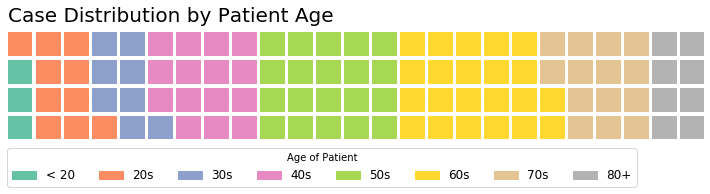

In [46]:
fig = plt.figure(
    FigureClass=Waffle, 
    rows=4,
    values=df_age.percent_of_tot,
    labels=list(df_age.age_range),
    legend={'loc': 'lower left',
            'bbox_to_anchor': (-.01, -0.5),
            'ncol': len(df_age.percent_of_tot),
            'fontsize': 12,
            'title':'Age of Patient'
           },
    title={'label': 'Case Distribution by Patient Age',
           'loc': 'left',
           'pad':10,
           'fontdict': {'fontsize': 20}},
    figsize=(10, 8)  # figsize is a parameter of plt.figure

)

In [47]:
bar_chart = pygal.Bar(x_label_rotation=20,
                      show_legend=False,
                      y_title='Percent of Cases (%)',
                      x_title='Age Group')
bar_chart.title = 'Case Distribution by Patient Age'
bar_chart.x_labels = df_age.age_range
bar_chart.add('% of Cases', df_age.percent_of_tot.to_list())

bar_chart.render_to_file('plots/age_range.svg')                          # Save the svg to a file

## Plot available hospital beds, ICU, ventilators

In [48]:
def find_occupied_assets(the_dict, total_asset, available_asset, return_col_name='occupied'):
    occupied_asset = []
    for idx in range(0, len(the_dict['date'])):
        if the_dict[total_asset][idx] is not None and the_dict[available_asset][idx] is not None:
            occupied_asset.append(the_dict[total_asset][idx] - the_dict[available_asset][idx])
        else:
            occupied_asset.append(None)
    
    the_dict[return_col_name] = occupied_asset
    return the_dict

In [49]:
def find_total_vent_including_alt(the_dict):
    total_vent_including_alt = []
    for idx in range(0, len(the_dict['date'])):
        if the_dict['total_ventilators'][idx] is not None and the_dict['alternative_ventilators'][idx] is not None:
            total_vent_including_alt.append(the_dict['total_ventilators'][idx] + the_dict['alternative_ventilators'][idx])
        else:
            total_vent_including_alt.append(None)
            
    the_dict['total_vent_including_alt'] = total_vent_including_alt
    return the_dict

In [50]:
def create_hospital_assets_dict():
    hosp_assets_dict = {'date':['2020-03-20','2020-03-21', '2020-03-22', '2020-03-23','2020-03-24',
                            '2020-03-25','2020-03-26','2020-03-27','2020-03-28','2020-03-29',
                            '2020-03-30','2020-03-31', '2020-04-01','2020-04-02','2020-04-03'],
                         'total_icu_beds':[135, None, None, None, None,
                                           151, 151, 164, None, None,
                                           176, 190, 272, 285, 289],
                         'available_icu_beds': [56, None, None, None, 77,
                                                83, 86, 86, None, None,
                                                92, 90, 124, 122, 110],
                         'total_ventilators':[291, None, None, None, None,
                                              306, 307, 308, None, None,
                                              309, 330, 348, 334, 324],
                         'available_ventilators':[218, None, None, None, 248,
                                                  248, 250, 247, None, None,
                                                  253, 262, 271, 266, 267],
                         'alternative_ventilators':[None, None, None, None, None,
                                                    None, None, 58, None, None,
                                                    87, 89, 128, 186, 199],
                         'respiratory_therapists':[None, None, None, None, 84,
                                                   88, None, None, None, None,
                                                   None, None, None, None, 127]
                        }
    # Calculate the number of occupied ICU Beds
    hosp_assets_dict = find_occupied_assets(hosp_assets_dict, 'total_icu_beds', 'available_icu_beds',
                                            return_col_name='occupied_icu_beds')
    hosp_assets_dict = find_occupied_assets(hosp_assets_dict, 'total_ventilators', 'available_ventilators',
                                            return_col_name='occupied_ventilators')
    hosp_assets_dict = find_total_vent_including_alt(hosp_assets_dict)

    return hosp_assets_dict

*numbers are going up because more hospitals are reporting to CDC

In [51]:
hosp_assets_dict = create_hospital_assets_dict()

custom_style = Style(
    colors=['#08519c', '#3182bd', '#6baed6'],
    label_font_size=14,
    major_guide_stroke_dasharray= '1.5,1.5',
    legend_font_size= 10
)

line_chart = pygal.Line(style=custom_style,
                        dots_size=2,
                        x_label_rotation=20,
                        show_minor_x_labels=False,
                        y_labels_major_every=2,
                        show_minor_y_labels=False,
                        width=750,
                        height=400,
                        truncate_legend=-1
                       )

line_chart.title = 'Statewide Ventilator Availablity'
line_chart.x_labels = hosp_assets_dict['date']
line_chart.x_labels_major = hosp_assets_dict['date'][0::3]

line_chart.add('Total Ventilators (including alternative)', hosp_assets_dict['total_vent_including_alt'],
               stroke_style={'width':2.5}, show_dots=1, dots_size=1)
line_chart.add('Total Traditional Ventilators', hosp_assets_dict['total_ventilators'],
               stroke_style={'width':2.5}, show_dots=1, dots_size=1)
line_chart.add('Occupied Ventilators', hosp_assets_dict['occupied_ventilators'],
              stroke_style={'dasharray': '3, 6', 'width':2.5})

line_chart.render_to_file('plots/ventilators.svg')                          # Save the svg to a file

In [52]:
hosp_assets_dict = create_hospital_assets_dict()


custom_style = Style(
    colors=['#08519c', '#3182bd'],
    label_font_size=14,
    major_guide_stroke_dasharray= '1.5,1.5'
)

line_chart = pygal.Line(style=custom_style,
                        dots_size=2.5,
                        x_label_rotation=20,
                        truncate_legend=-1,
                        show_minor_x_labels=False,
                        y_labels_major_every=2,
                        show_minor_y_labels=False
                        )
line_chart.title = 'Statewide ICU Bed Availablity'
line_chart.x_labels = hosp_assets_dict['date']
line_chart.x_labels_major = hosp_assets_dict['date'][0::3]

line_chart.add('Total ICU Beds', hosp_assets_dict['total_icu_beds'], stroke_style={'width':2.5},
               show_dots=1, dots_size=1)
line_chart.add('Occupied ICU Beds', hosp_assets_dict['occupied_icu_beds'],
               stroke_style={'dasharray': '3, 6', 'width':2.5})
# stroke_style={'width':2.5}


line_chart.render_to_file('plots/icu_beds.svg')                          # Save the svg to a file

